# Inicialización

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal, fft
from IPython.display import Audio
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [2]:
dir_files = './data/'

In [3]:
def cargar_audio(directorio, nombre, mono=False):
    # Cargar audio
    sr, data = io.wavfile.read(directorio+nombre)

    if mono:
        # Pasar de estéreo a mono
        if len(data.shape) > 1:
            data = (data[:,0].astype(float) + data[:,1].astype(float))/2

    # normalize maximum (absolute) amplitude
    data = data / np.max(abs(data)) * 0.9

    return sr, data

# Cepstrum

## Funciones

In [6]:
def cepstrum(s, N_f):
    N = len(s)
    N_ceps = 2*N

    S = fft.fft(s, n=N_ceps)

    magS = np.abs(S)

    S_hat = np.log(magS+1e-13)
    s_hat = fft.ifft(S_hat).real

    s_cepstrum = s_hat[:N]
    s_cepstrum[:N_f] = 0

    return s_cepstrum

In [7]:
def ST_cepstrum(s, L=2048, R=256, win='hann', N_f=80):
    """ compute the analysis phase of the phase vocoder, i.e. the STFT of the input audio signal
    
    Parameters
    ----------
    x : numpy array
        input audio signal (mono) as a numpy 1D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.    
        
    Returns
    -------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    omega_stft : numpy array
                 frequency values in radians.
    samps_stft : numpy array
                 time sample at the begining of each frame.

    """
    
    # length of the input signal
    M = s.size;      
    
    # number of points to compute the cepstrum
    N = L
    
    # analysis window
    window = signal.windows.get_window(win, L)
   
    # total number of analysis frames
    num_frames = int(np.floor((M - L) / R))

    # initialize stft
    s_hat = np.zeros((N, num_frames))
    
    # process each frame
    for ind in range(num_frames):

        # initial and ending points of the frame
        n_ini = int(ind * R)
        n_end = n_ini + L

        # signal frame
        s_w = window*s[n_ini:n_end]

        # save DFT of the signal frame
        s_hat[:, ind] = cepstrum(s_w, N_f)
        
    # frequency values in radians    
    quefrencys = np.arange(N)

    # # time sample at the center of each frame
    samps_ceps = np.arange(L/2, M-L/2+1, R)[:-1]
 
    return s_hat, samps_ceps, quefrencys

In [8]:
def frecuencia_fundamental(cepstrum, quefrencys, sr):

    N = cepstrum.shape[1]
    pf_ind = np.zeros(N, dtype=int)

    for i in range(N):
        if np.max(cepstrum[:,i])>0.2:
            pf_ind[i] = np.argmax(cepstrum[:,i])
        else:
            pf_ind[i] = 0

    pf = quefrencys[pf_ind]
    ff = sr//pf

    return ff

## Prueba

In [113]:
sr, s = cargar_audio(dir_files, 'Emily_Linge-vocals.wav', mono=True)
s = s[:100*sr]
Audio(s, rate=sr)

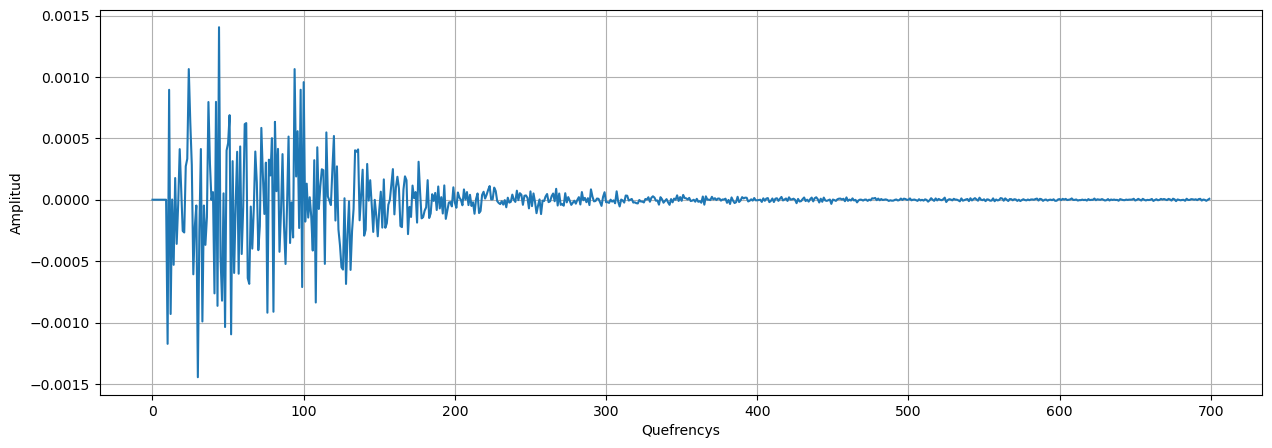

In [114]:
s_ceps = cepstrum(s[258000:258700], N_f=10)
plt.figure(figsize=(15,5))
plt.plot(s_ceps)
plt.xticks(np.arange(0,701,100))
plt.xlabel('Quefrencys')
plt.ylabel('Amplitud')
plt.grid()

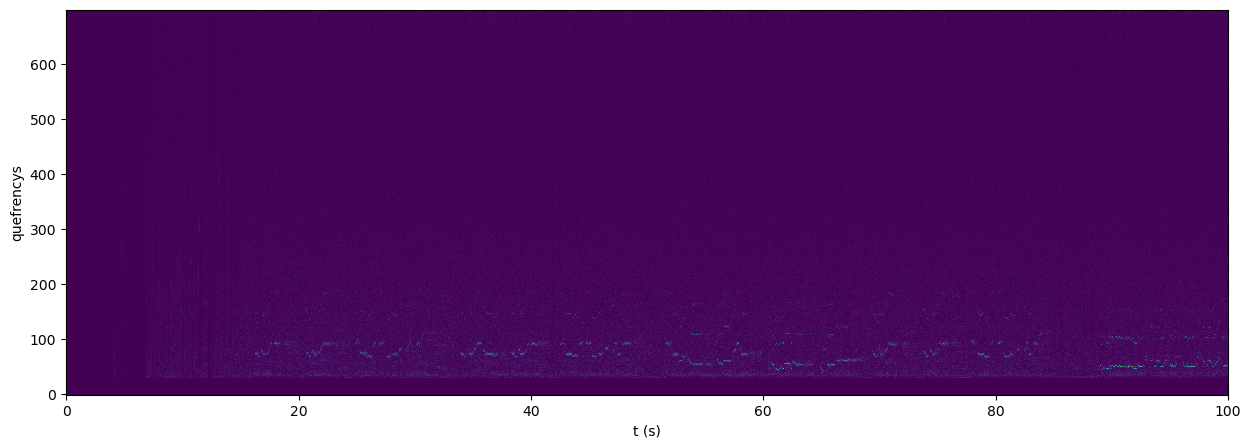

In [115]:
[s_hat, samps_ceps, quefrencys] = ST_cepstrum(s, L=700, R=700, N_f=30)
t = np.linspace(0, len(s)/sr, len(samps_ceps))
plt.figure(figsize=(15,5))
plt.pcolormesh(t, quefrencys, abs(s_hat), shading='auto')
plt.xlabel("t (s)")
plt.ylabel("quefrencys");

In [116]:
ff = frecuencia_fundamental(s_hat, quefrencys, sr)

C:\Users\bener\AppData\Local\Temp\ipykernel_5716\1416048013.py:13: RuntimeWarning: divide by zero encountered in floor_divide
  ff = sr//pf


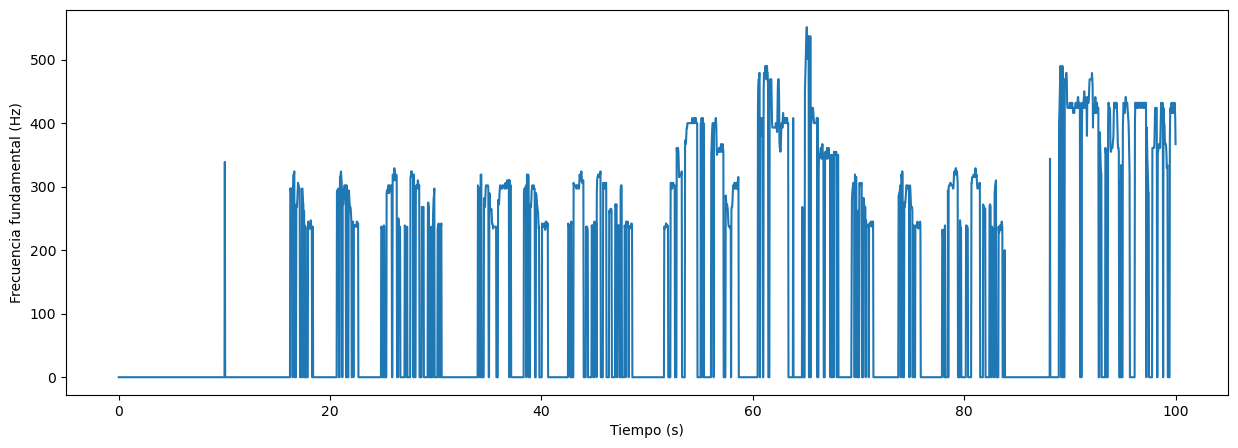

In [117]:
plt.figure(figsize=(15,5))
plt.plot(t, ff, 'tab:blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia fundamental (Hz)');

In [118]:
print(ff)
print(np.unique(ff))

[  0   0   0 ... 424 408 367]
[  0 132 200 225 227 229 232 234 237 239 242 245 247 250 253 256 259 262
 265 268 272 275 279 282 286 290 294 297 302 306 310 315 319 324 329 334
 339 344 350 355 361 367 373 380 386 393 400 408 416 424 432 441 450 459
 469 479 490 501 512 525 537 551]


# Desviación de Frecuencia

## Funciones

In [9]:
def obtener_notas(ref=440, Ndown=24, Nup=24):
    # Devuelve array con Ndown notas anteriores a ref (estimación de A4) y Nup notas posteriores
    # Valores por defecto para ir de A2 a A6 con referencia A4 puro

    notas = np.zeros(Ndown+Nup+1)
    A4 = Ndown
    notas[A4] = ref

    for i in range(Ndown):
        notas[A4-i-1] = notas[A4-i]*2**(-1/12)
    for i in range(Nup):
        notas[A4+i+1] = notas[A4+i]*2**(1/12)
    
    return notas

In [10]:
def distancia_notas(notas, ff):
    N = len(ff)
    distancias = np.zeros(N)
    distancias_indmin = np.zeros(N, dtype=int)
    
    for i in range(N):
        if ff[i]==0:
            distancias[i] = np.inf
            distancias_indmin[i] = -1
        else:
            distancias_indmin[i] = np.argmin(np.abs(12*np.log2(ff[i]/notas)))
            distancias[i] = 12*np.log2(ff[i]/notas[distancias_indmin[i]])

    return distancias, distancias_indmin

In [11]:
def desviacion_A4(distancias):

    desviacion_media = np.mean(distancias[np.isfinite(distancias)])
    desviacion_mediana = np.median(distancias[np.isfinite(distancias)])

    return desviacion_media, desviacion_mediana

In [12]:
def estandarizar_notas(notas, indices):

    N = len(indices)
    notas_estandar = np.zeros(N)

    for i in range(N):
        if indices[i] == -1:
            notas_estandar[i] = 0
        else:
            notas_estandar[i] = notas[indices[i]]

    return notas_estandar

## Prueba

In [125]:
notas = obtener_notas()
dist, dist_indmin = distancia_notas(notas, ff)
desv_media, desv_mediana = desviacion_A4(dist)
print('La desviación media es de', desv_media, 'semitonos')
print('La mediana de la desviación es de', desv_mediana, 'semitonos')

La desviación media es de 0.11468970644350887 semitonos
La mediana de la desviación es de 0.19551288731327082 semitonos


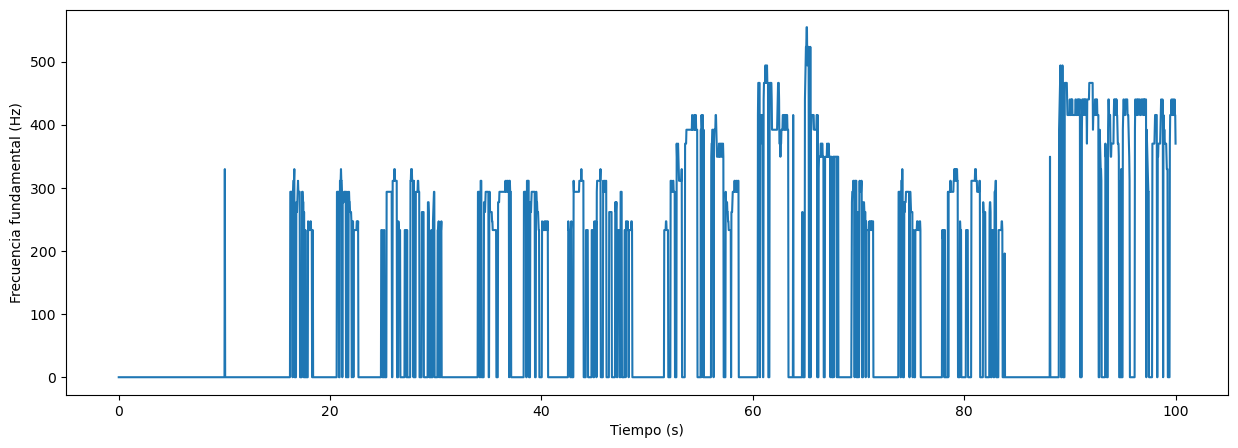

In [91]:
ff_estandar = estandarizar_notas(notas, dist_indmin)

plt.figure(figsize=(15,5))
plt.plot(t, ff_estandar, 'tab:blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia fundamental (Hz)');

# Correspondencia temporal

In [36]:
emily_sr, emily = cargar_audio(dir_files, 'Emily_Linge-vocals.wav', mono=True)
emily = emily[15*emily_sr:100*emily_sr]
police_sr, police = cargar_audio(dir_files, 'Police-vocals-guitar.wav', mono=True)
police = police[15*emily_sr:100*police_sr]

In [37]:
[emily_cepstrum, emily_samps, quefrencys] = ST_cepstrum(emily, L=700, R=700, N_f=30)
[police_cepstrum, police_samps, quefrencys] = ST_cepstrum(police, L=700, R=700, N_f=30)

In [38]:
emily_ff = frecuencia_fundamental(emily_cepstrum, quefrencys, emily_sr)
police_ff = frecuencia_fundamental(police_cepstrum, quefrencys, police_sr)

C:\Users\bener\AppData\Local\Temp\ipykernel_1292\1416048013.py:13: RuntimeWarning: divide by zero encountered in floor_divide
  ff = sr//pf


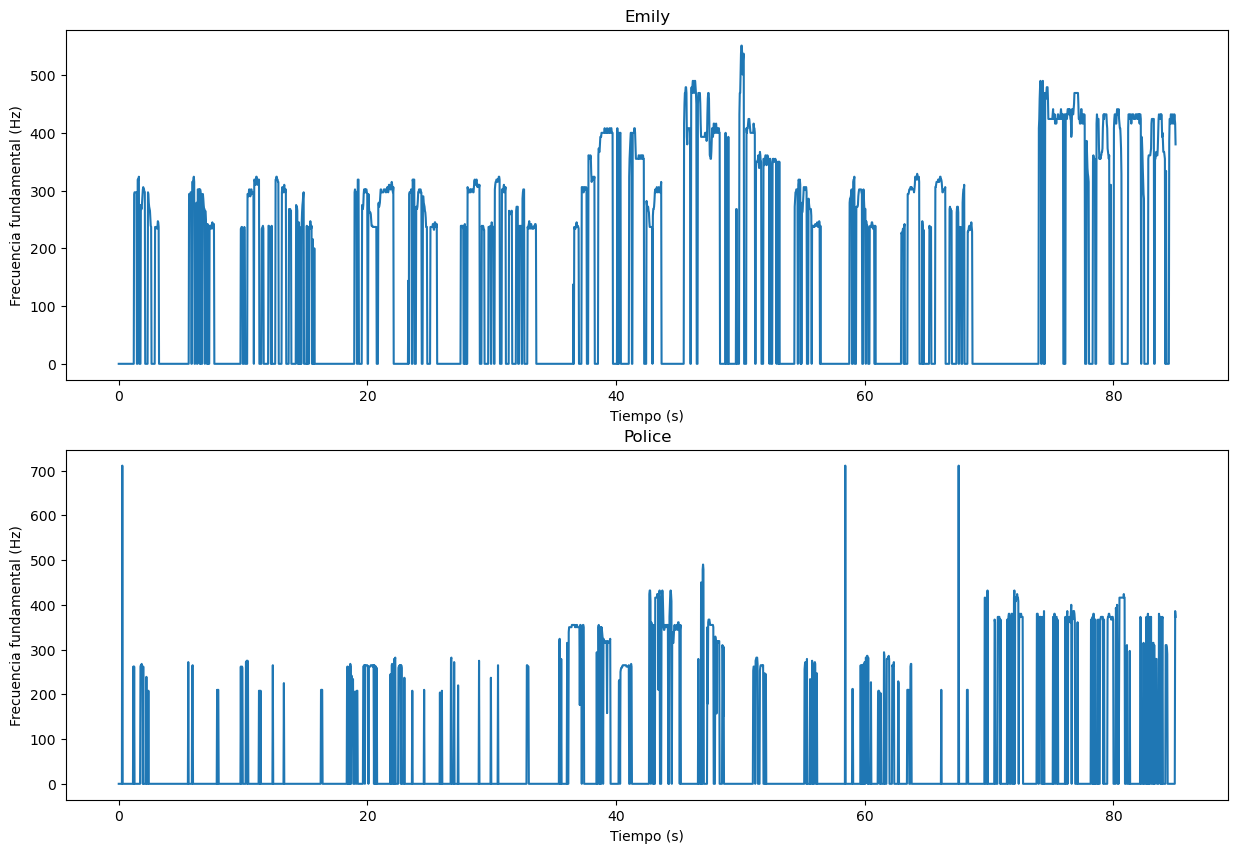

In [39]:
emily_t = np.linspace(0, len(emily)/emily_sr, len(emily_samps))
police_t = np.linspace(0, len(police)/police_sr, len(police_samps))

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
axs[0].plot(emily_t, emily_ff)
axs[0].set_title('Emily')
axs[0].set_xlabel('Tiempo (s)')
axs[0].set_ylabel('Frecuencia fundamental (Hz)')
axs[1].plot(police_t, police_ff)
axs[1].set_title('Police')
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Frecuencia fundamental (Hz)');

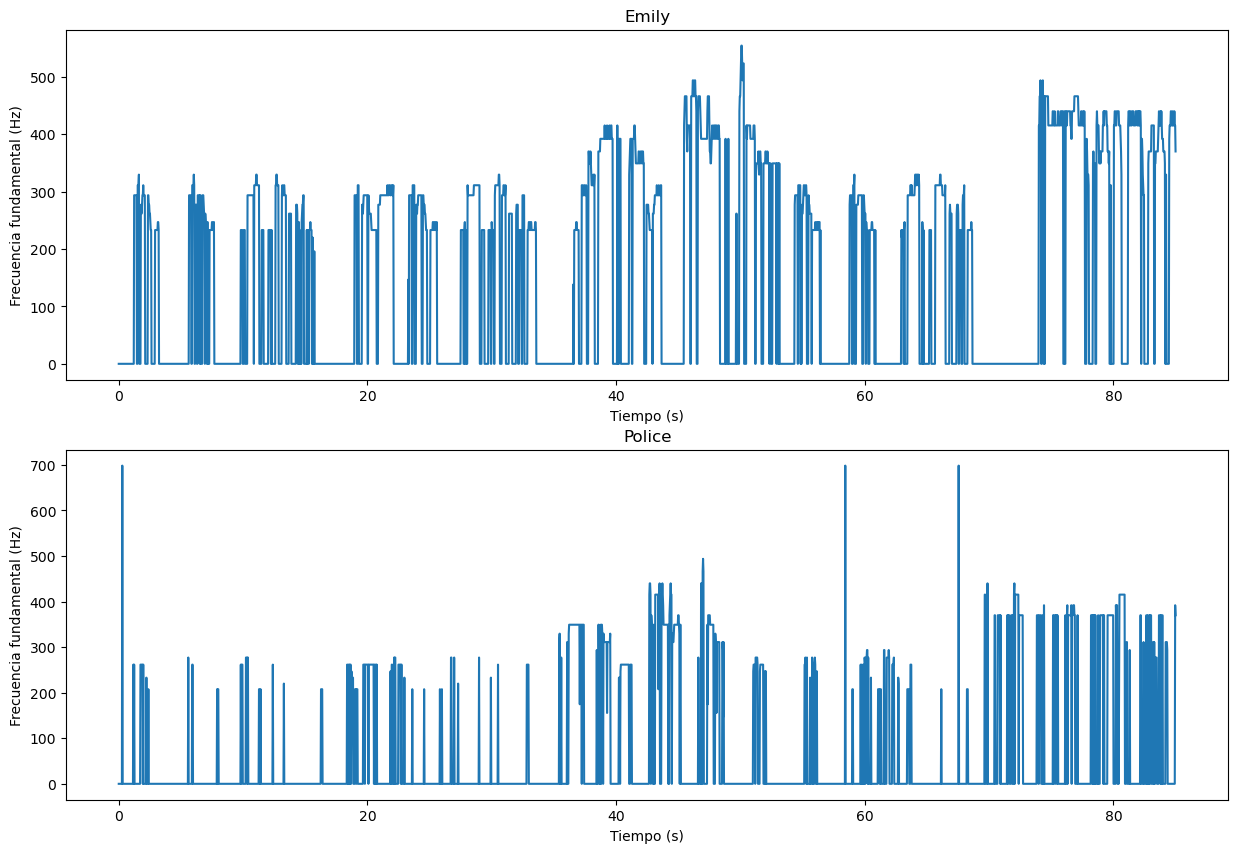

In [40]:
notas = obtener_notas()
emily_dist, emily_dist_indmin = distancia_notas(notas, emily_ff)
emily_ff_est = estandarizar_notas(notas, emily_dist_indmin)
police_dist, police_dist_indmin = distancia_notas(notas, police_ff)
police_ff_est = estandarizar_notas(notas, police_dist_indmin)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
axs[0].plot(emily_t, emily_ff_est)
axs[0].set_title('Emily')
axs[0].set_xlabel('Tiempo (s)')
axs[0].set_ylabel('Frecuencia fundamental (Hz)')
axs[1].plot(police_t, police_ff_est)
axs[1].set_title('Police')
axs[1].set_xlabel('Tiempo (s)')
axs[1].set_ylabel('Frecuencia fundamental (Hz)');

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

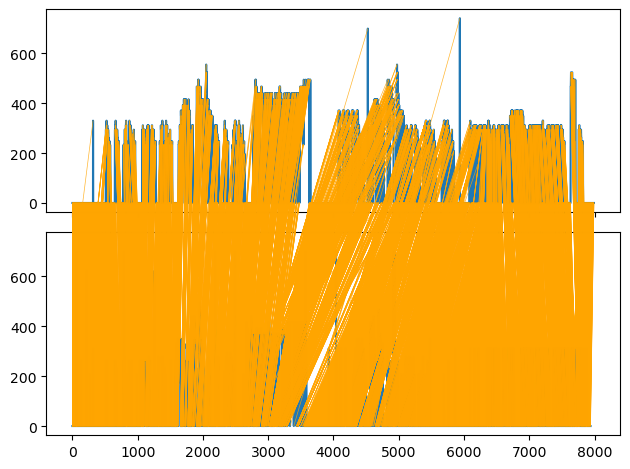

In [19]:
path = dtw.warping_path(emily_ff_est, police_ff_est)
dtwvis.plot_warping(emily_ff_est, police_ff_est, path)

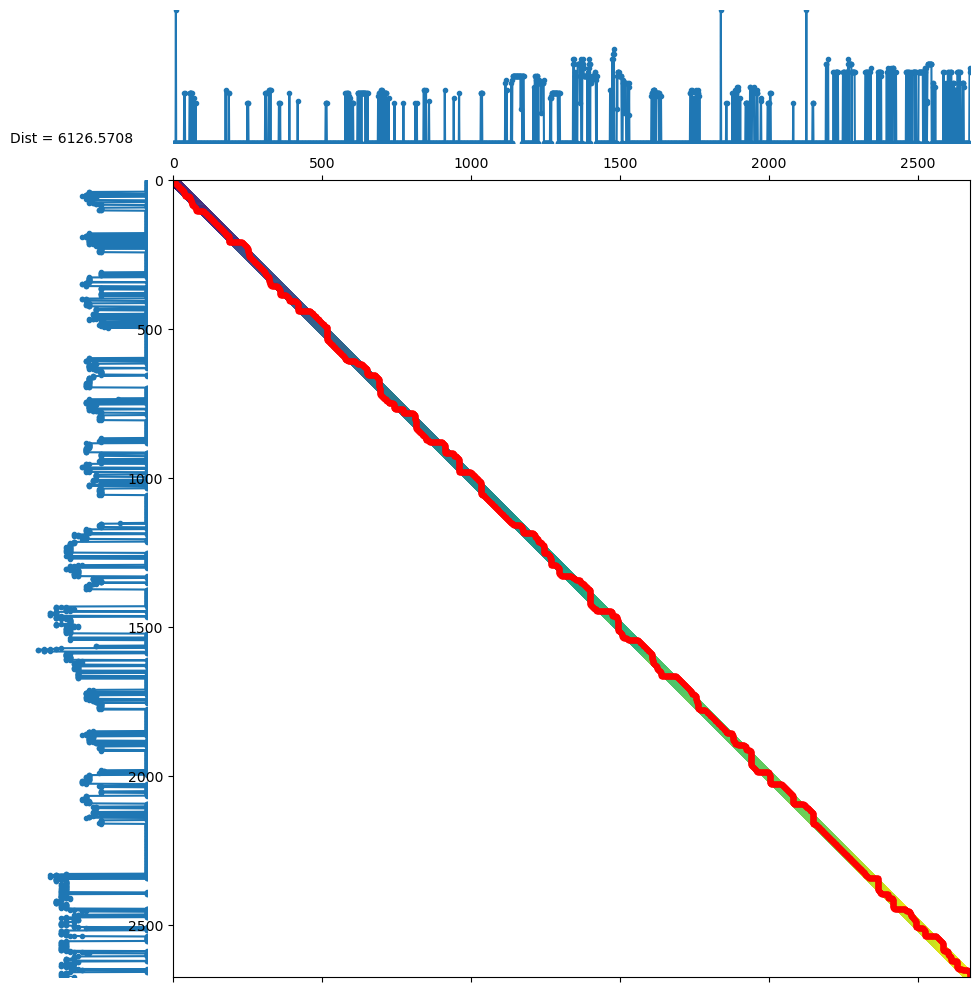

In [41]:
d, paths = dtw.warping_paths(emily_ff_est, police_ff_est, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(emily_ff_est, police_ff_est, paths, best_path);

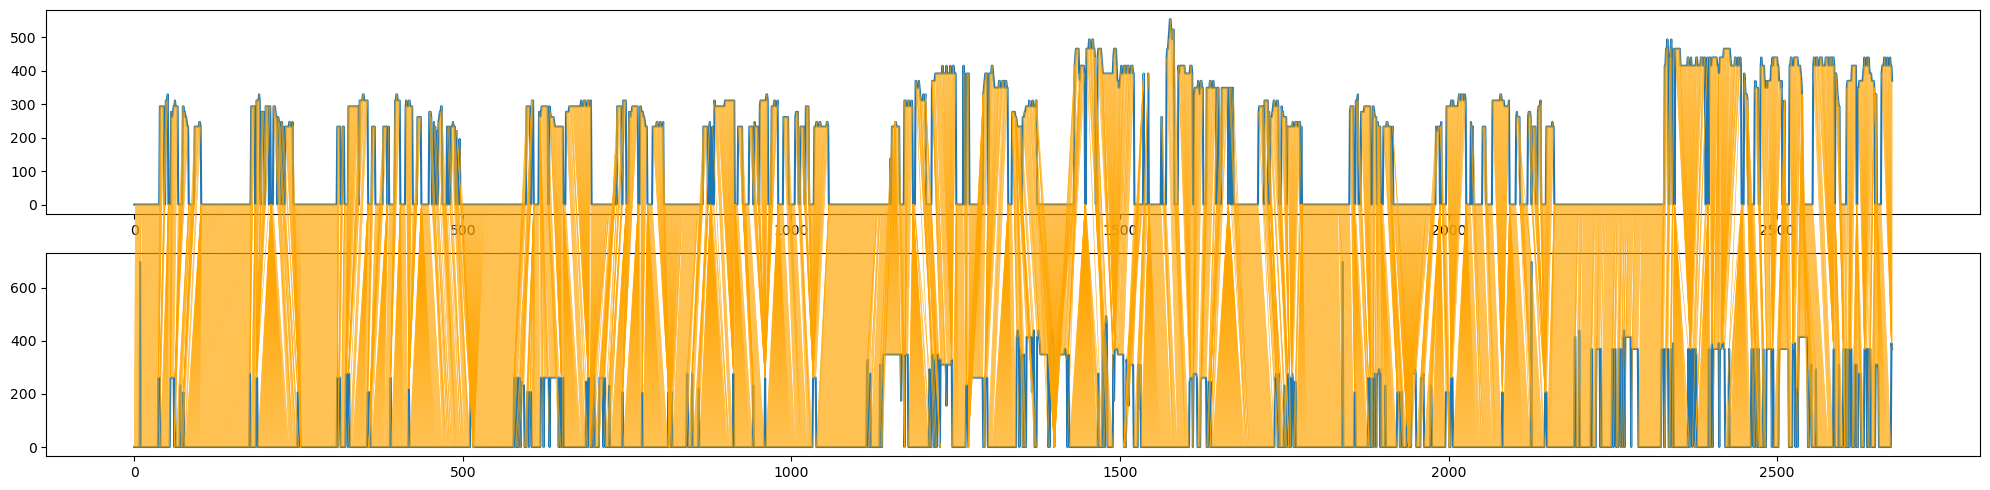

In [42]:
warping_figure, warping_axs = plt.subplots(nrows=2, ncols=1, figsize=(20,5))
dtwvis.plot_warping(emily_ff_est, police_ff_est, best_path, fig=warping_figure, axs=warping_axs);